In [30]:
import sys
import numpy as np
import import_ipynb
from pathlib import Path
from scipy.sparse.linalg import spsolve
from IPython.display import SVG, display

# Adicionar o diretório raiz do projeto ao sys.path
project_root = Path().resolve().parent  
sys.path.append(str(project_root))
print("Project root added to sys.path:", project_root)

# Importando notebooks diretamente
try:
    import problem_statement as ps  
    from fem_processing import matrices_assembly as assembly
    from fem_pos_processing import graph_results as graph
    print("Modules imports were successful!")
except ModuleNotFoundError as key:
    print(f"Modules were not found: {key}")
except ImportError as key:
    print(f"Error in import: {key}")
    
#run ../setup_project.py

Project root added to sys.path: C:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF
Modules imports were successful!


# Project 1: Poisson Problem at Rectangular Domain $\Omega = [0,1]^2$

Considere um problema de _Poisson_ 2D em $\Omega = [0,1]^2$

$$
-\nabla \cdot \left( \nabla u(x,y) \right) = f(x,y)
\tag{1}
$$

onde,
$$
f(x,y) = 2\pi^2 \, sin(\pi x) \, sin(\pi y)
\tag{2}
$$

cujas condições de contorno são $u=0$ em $\partial \Omega$.

A solução analítica deste problema é

$$
u(x,y) = sin(\pi x) \, sin(\pi y)
\tag{3}
$$

Implemente um programa de elementos finitos utilizando elementos triangulares $P_1$ para resolver o Problema de Valor de Contorno $(1)$.

# 3-noded Linear Triangular Elements, $P_1$
## Pre-processor module
### Geometry and mesh Domain

In [31]:
FINITE_ELEMENT = ("Triangle", 1)
BOUNDARY = [{'tag': 101, 'type': 'Dirichlet', 'value': 0.0, 'name': 'omega'}]
MATERIAL = [{'tag': 201, 'name': 'free_space', 'a_constant': 1}]

# Create mesh from file geometry
mesh_data = ps.create_domain(FINITE_ELEMENT, BOUNDARY, MATERIAL, h=0.02, view_mesh=False)

Malha salva em pre_processing/mesh/rectangular_domain_Triangle1.msh
Model rectangular_domain (2D)
Info     : 9 geometric entities
Info     : 2 Physical Groups
Info     : 3013 nodes in total
Info     : 5824 2-D elements in total


### Figure 1: Rectangular meshed domain $\Omega=[0,1]^2$

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p11_poisson_problem\pre_processing\pictures\meshed_domain_Triangle1_EntireDomain.svg


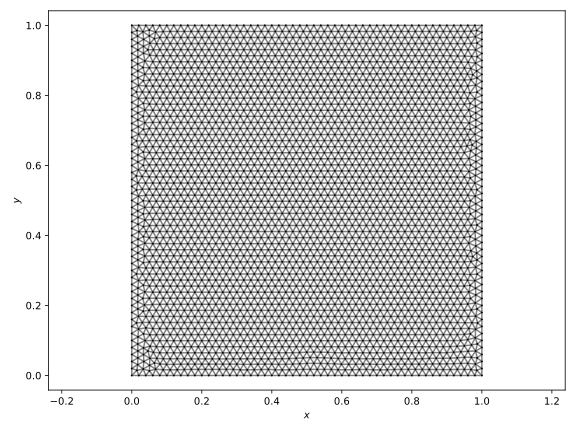

In [32]:
graph.plot_mesh(FINITE_ELEMENT, mesh_data)
display(SVG(filename="pre_processing/pictures/meshed_domain_Triangle1_EntireDomain.svg"))

### Mesh Data Dictionaries

In [33]:
cell_data = mesh_data['cell']; cell_data[1]

{'conn': [2886, 1750, 2997],
 'conn_sorted': [1750, 2886, 2997],
 'conn_edge': None,
 'geo': {'centroid': None, 'area': None},
 'contour': {'type': None, 'conn_contour': None},
 'material': {'tag': 201, 'name': 'free_space', 'a_constant': 1},
 'stiffness_term': [array([[1., 0.],
         [0., 1.]]),
  array([[1., 0.],
         [0., 1.]]),
  array([[1., 0.],
         [0., 1.]]),
  array([[1., 0.],
         [0., 1.]]),
  array([[1., 0.],
         [0., 1.]]),
  array([[1., 0.],
         [0., 1.]]),
  array([[1., 0.],
         [0., 1.]])],
 'mass_term': [1, 1, 1, 1, 1, 1, 1],
 'source': [1.0057787735261516,
  1.1970935519534498,
  0.8860896485885278,
  0.9361614939053862,
  0.6933466196088213,
  1.2012841297748802,
  1.1285216489253334],
 'abc': {'type': None, 'conn_idx': None}}

In [34]:
nodes_data = mesh_data['nodes']; nodes_data[1]

{'xg': (0.0, 0.0),
 'bc': {'tag': 101, 'type': 'Dirichlet', 'value': 0.0, 'name': 'omega'}}

In [35]:
conn_data = {key: cell['conn'] for key, cell in cell_data.items()}; conn_data[1]

[2886, 1750, 2997]

### ``global_nodes_coordinates()``

In [36]:
nodes_coord = {key: value['xg'] for key, value in nodes_data.items()}; nodes_coord[1]

(0.0, 0.0)

### $x_g, y_g$ global coordinate

In [37]:
xg = {key: value['xg'][0] for key, value in nodes_data.items()}; xg[1]

0.0

### $a_e = (x_e, y_e)$ global element coordinate

In [38]:
aie = {key: [nodes_data[idx]['xg'] for idx in node_ids] for key, node_ids in conn_data.items()}; aie[1]

[(0.9822770422604864, 0.8290977806652943),
 (0.9598919009022603, 0.8268778375561322),
 (0.9663776086177377, 0.8073830225305368)]

In [39]:
print("'Node 1' global coordinates: ", nodes_data[1]['xg'])

'Node 1' global coordinates:  (0.0, 0.0)


In [40]:
xi = {key: [coord[0] for coord in coords] for key, coords in aie.items()}; xi[1]

[0.9822770422604864, 0.9598919009022603, 0.9663776086177377]

### `map_to_physical_coordinates()`

In [41]:
xi_master = (0, 1)
xge, yge = assembly.isomapping_to_global_coordinates(FINITE_ELEMENT, aie[1], xi_master)
print(f"'e_1' Master coordinates: {xi_master} --> Global coordinates: ({xge}, {yge})")

'e_1' Master coordinates: (0, 1) --> Global coordinates: (0.9663776086177377, 0.8073830225305368)


### Local Elements $e_1$

In [42]:
Je = assembly.jacobian(FINITE_ELEMENT, mesh_data, cell_data[1], xi_master) 
Jdet, Jinv = np.abs(np.linalg.det(Je)), np.linalg.inv(Je)
print("Determinant of the Jacobian matrix for element e_1:", Jdet)
graph.matrix2table(Je, title="Jacobian matrix 'Je' for cell 1")

Determinant of the Jacobian matrix for element e_1: 0.00045079209225143565


### Shape functions and derivatives

In [43]:
varphi, dN_dxi, dN_deta, grad_phi = assembly.derivatives_at_master_domain(FINITE_ELEMENT, xi_master)
graph.matrix2table(varphi, title="Shape functions at master domain")
graph.matrix2table(grad_phi, title="Derivatives of the shape functions at master domain")

### Material Proprieties, $k_a$

In [44]:
kae = mesh_data['cell'][1]['stiffness_term']
graph.matrix2table(kae, title="Stiffness matrix 'ka_e' for cell 1")

### Matriz de rigidez

In [45]:
Be = Jinv @ grad_phi
graph.matrix2table(Be, title="Gradient matrix 'Be' for cell 1")

### Local “stiffness” matrix, $A_e$

In [46]:
Ae, fe, Me, Pe, Qe = assembly.local_matrices(FINITE_ELEMENT, mesh_data, cell_data[1])
graph.matrix2table(Ae.real, title="Local stiffness matrix for cell 1, 'Ae_1'")
graph.matrix2table(fe.real, title="Local load vector for cell 1, 'fe_1'")

### Global “stiffness” matrix, $A_g$

In [47]:
Ag, fg, Mg, Pg, Qg = assembly.global_matrices(FINITE_ELEMENT, mesh_data)
print("Global matrix shape:", Ag.shape)

Global matrix shape: (3013, 3013)


### Boundary Conditions

In [48]:
dirichlet_nodes = {key: value 
                   for key, value in nodes_data.items() if value['bc']['type'] == 'Dirichlet'}
free_nodes = {key: value 
              for key, value in nodes_data.items() if value['bc']['type'] != 'Dirichlet'}

Nn = len(nodes_data)
Nd = len(dirichlet_nodes)
print(f"The entire domain has {Nn} nodes: {Nn - Nd} free nodes; {Nd} Dirichlet nodes.")

The entire domain has 3013 nodes: 2813 free nodes; 200 Dirichlet nodes.


### Mapping Global nodes to reduced system

This code creates a dictionary called ``global_to_reduced``, which maps the global indices of the mesh nodes to the reduced indices, i.e. the indices that correspond only to the nodes that are not in the _Dirichlet boundary conditions_.

In [49]:
mapping_global = {global_id: idx + 1 for idx, global_id in enumerate(free_nodes.keys())}

## Processor Module
### Asymmetric Global matrix $A_g$ with boundary conditions

In [50]:
Ag, fg = assembly.apply_simple_dirichlet(Ag, fg, mesh_data)
print("Global matrix shape:", Ag.shape)

Global matrix shape: (3013, 3013)


### Global Potential Vector

> Make sure Ag is in CSR format for efficiency  
> Convert fg to a dense format or keep it sparse as needed  
> Solve the linear system Ag * u = fg

In [51]:
ug = spsolve(Ag.tocsr(), fg.toarray())
print("Global Potencial Vector shape:", ug.shape)

Global Potencial Vector shape: (3013,)


### Reduced Global matrix $A_{gr}$ with boundary conditions

In [52]:
Sgr, fgr, Mgr, Pgr, Qgr = assembly.reduced_global_matrices(FINITE_ELEMENT, mesh_data)
print("Reduced global matrix shape:", Sgr.shape)

Reduced global matrix shape: (2813, 2813)


### Global Potential Solution

In [53]:
uhr = spsolve(Sgr.tocsr(), fgr.toarray())
uh = assembly.global_potentials_solution(mesh_data, uhr)
print("Reduced Potencial Vector shape:", uhr.shape)
print("Global Potencial Vector dimension:", len(uh))

Reduced Potencial Vector shape: (2813,)
Global Potencial Vector dimension: 3013


### Solution at each element

In [54]:
u_at_cell = {}
for key, cell in cell_data.items():
    u_at_cell[key] = [uh[node] for node in cell['conn']]
graph.matrix2table(np.array(u_at_cell[1]).real, title="The complete solution for cell 1")

### Interpolate Solution at element, $e_n$

In [55]:
u_at_node = assembly.isomapping_to_global_coordinates(FINITE_ELEMENT, u_at_cell[1], xi_master)
print(f"Element e_{key}: Potential 'u' interpolate at xi = {xi_master} --> u(xi): {u_at_node}")

Element e_5824: Potential 'u' interpolate at xi = (0, 1) --> u(xi): [0.05994092+0.j]


## Post-Processor

### Figure 2: Scalar Field Distribution on a Triangular Mesh

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p11_poisson_problem\pos_processing\pictures\fem_solution_Triangle1_EntireDomain.svg


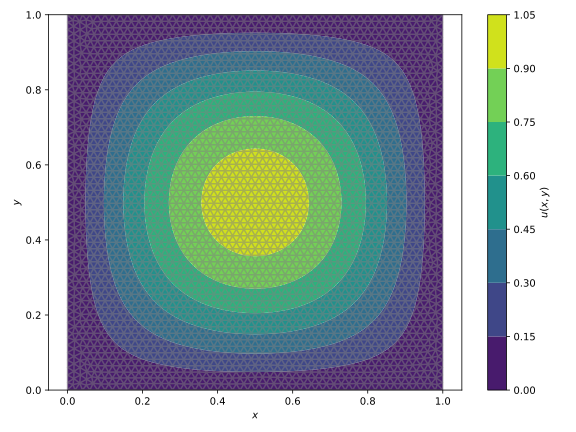

In [56]:
graph.fem_solution(FINITE_ELEMENT, mesh_data, uh)
display(SVG(filename="pos_processing/pictures/fem_solution_Triangle1.svg"))

### Figure 3: Scalar Field Distribution and Triangular Mesh

In [57]:
graph.fem_solution(FINITE_ELEMENT, mesh_data, uh)
display(SVG(filename="pos_processing/pictures/fem_solution_griddata_Triangle1.svg"))

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p11_poisson_problem\pos_processing\pictures\fem_solution_Triangle1_EntireDomain.svg


### Figure 4: Analytical Scalar Field Distribution on a Triangular Mesh

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p11_poisson_problem\pos_processing\pictures\analytical_solution.svg


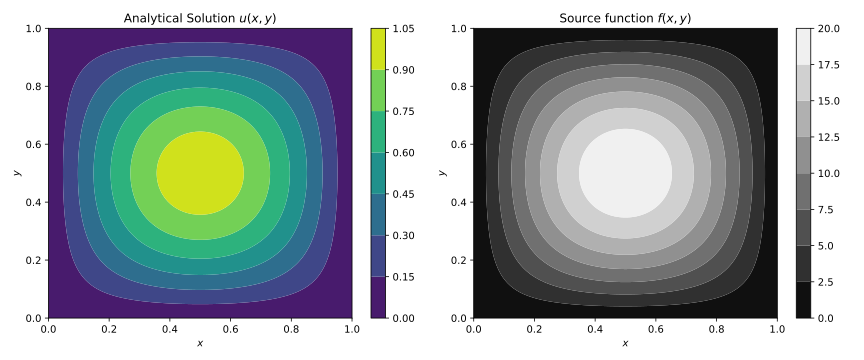

In [58]:
ps.plot_analytical_solution(Npts=100)
display(SVG(filename="pos_processing/pictures/analytical_solution.svg"))

Conversão do arquivo Jupyter Notebook para um script Python: ``python -m nbconvert --to script name.ipynb``

Belo Horizonte, Brazil. 2024.  
Adilton Junio Ladeira Pereira - adt@ufmg.br  
&copy; All rights reserved.